<a href="https://colab.research.google.com/github/jinmyeonghee/project2/blob/main/AI_16_%EC%A7%84%EB%AA%85%ED%9D%AC_section2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install category_encoders
!pip install eli5
!pip install pdpbox
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from xgboost import XGBRegressor

%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import eli5
from eli5.sklearn import PermutationImportance

## Predicting Customer Satisfaction
### 항공사의 설문조사 데이터가 주어지면 고객 만족도를 예측할 수 있습니까?

In [3]:
train = pd.read_csv('https://raw.githubusercontent.com/jinmyeonghee/project2/main/project2_satisfaction_train.csv', index_col = 0)
test = pd.read_csv('https://raw.githubusercontent.com/jinmyeonghee/project2/a4404029b8bfa3c61ce01f8af81b1afc584e770e/project2_satisfaction_test.csv', index_col = 0)


In [4]:
train

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103899,94171,Female,disloyal Customer,23,Business travel,Eco,192,2,1,2,...,2,3,1,4,2,3,2,3,0.0,neutral or dissatisfied
103900,73097,Male,Loyal Customer,49,Business travel,Business,2347,4,4,4,...,5,5,5,5,5,5,4,0,0.0,satisfied
103901,68825,Male,disloyal Customer,30,Business travel,Business,1995,1,1,1,...,4,3,2,4,5,5,4,7,14.0,neutral or dissatisfied
103902,54173,Female,disloyal Customer,22,Business travel,Eco,1000,1,1,1,...,1,4,5,1,5,4,1,0,0.0,neutral or dissatisfied


In [5]:
train['id'].duplicated().sum()
# id 중복 없음

0

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103904 entries, 0 to 103903
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 103904 non-null  int64  
 1   Gender                             103904 non-null  object 
 2   Customer Type                      103904 non-null  object 
 3   Age                                103904 non-null  int64  
 4   Type of Travel                     103904 non-null  object 
 5   Class                              103904 non-null  object 
 6   Flight Distance                    103904 non-null  int64  
 7   Inflight wifi service              103904 non-null  int64  
 8   Departure/Arrival time convenient  103904 non-null  int64  
 9   Ease of Online booking             103904 non-null  int64  
 10  Gate location                      103904 non-null  int64  
 11  Food and drink                     1039

In [7]:
train.columns

Index(['id', 'Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
       'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

In [8]:
train['satisfaction'].unique()

array(['neutral or dissatisfied', 'satisfied'], dtype=object)

만족도에는 '중립과 불만족'이 한 항목으로 있고, '만족'이 있습니다. 저희는 고객들이 원하는 욕구를 충족시켜 고객의 이탈 등의 방지를 위해 '중립과 불만족'이 나오지 않도록 개선해야 합니다. 
각 서비스의 리커트척도와 만족과 불만족의 상관관계를 분석하고 개선방안을 찾아야 할 것입니다.
항공사 이용자 만족도 조사결과는 항공사와 공항에서 이용자에게 제공하는 항공서비스 개선을 위한 기초자료로 활용되어집니다. 만족도 조사결과로 서비스에 '만족'했는지, 하지 않았는지 예측하여 항공사와 공항의 서비스 향상으로 이어질 수 있도록 반영해야 할 것입니다.

먼저 각 데이터가 어떻게 분포되어있는지 수치형데이터들은 히스토그램으로 살펴보고, 범주형데이터에 대해서도 살펴보겠습니다.

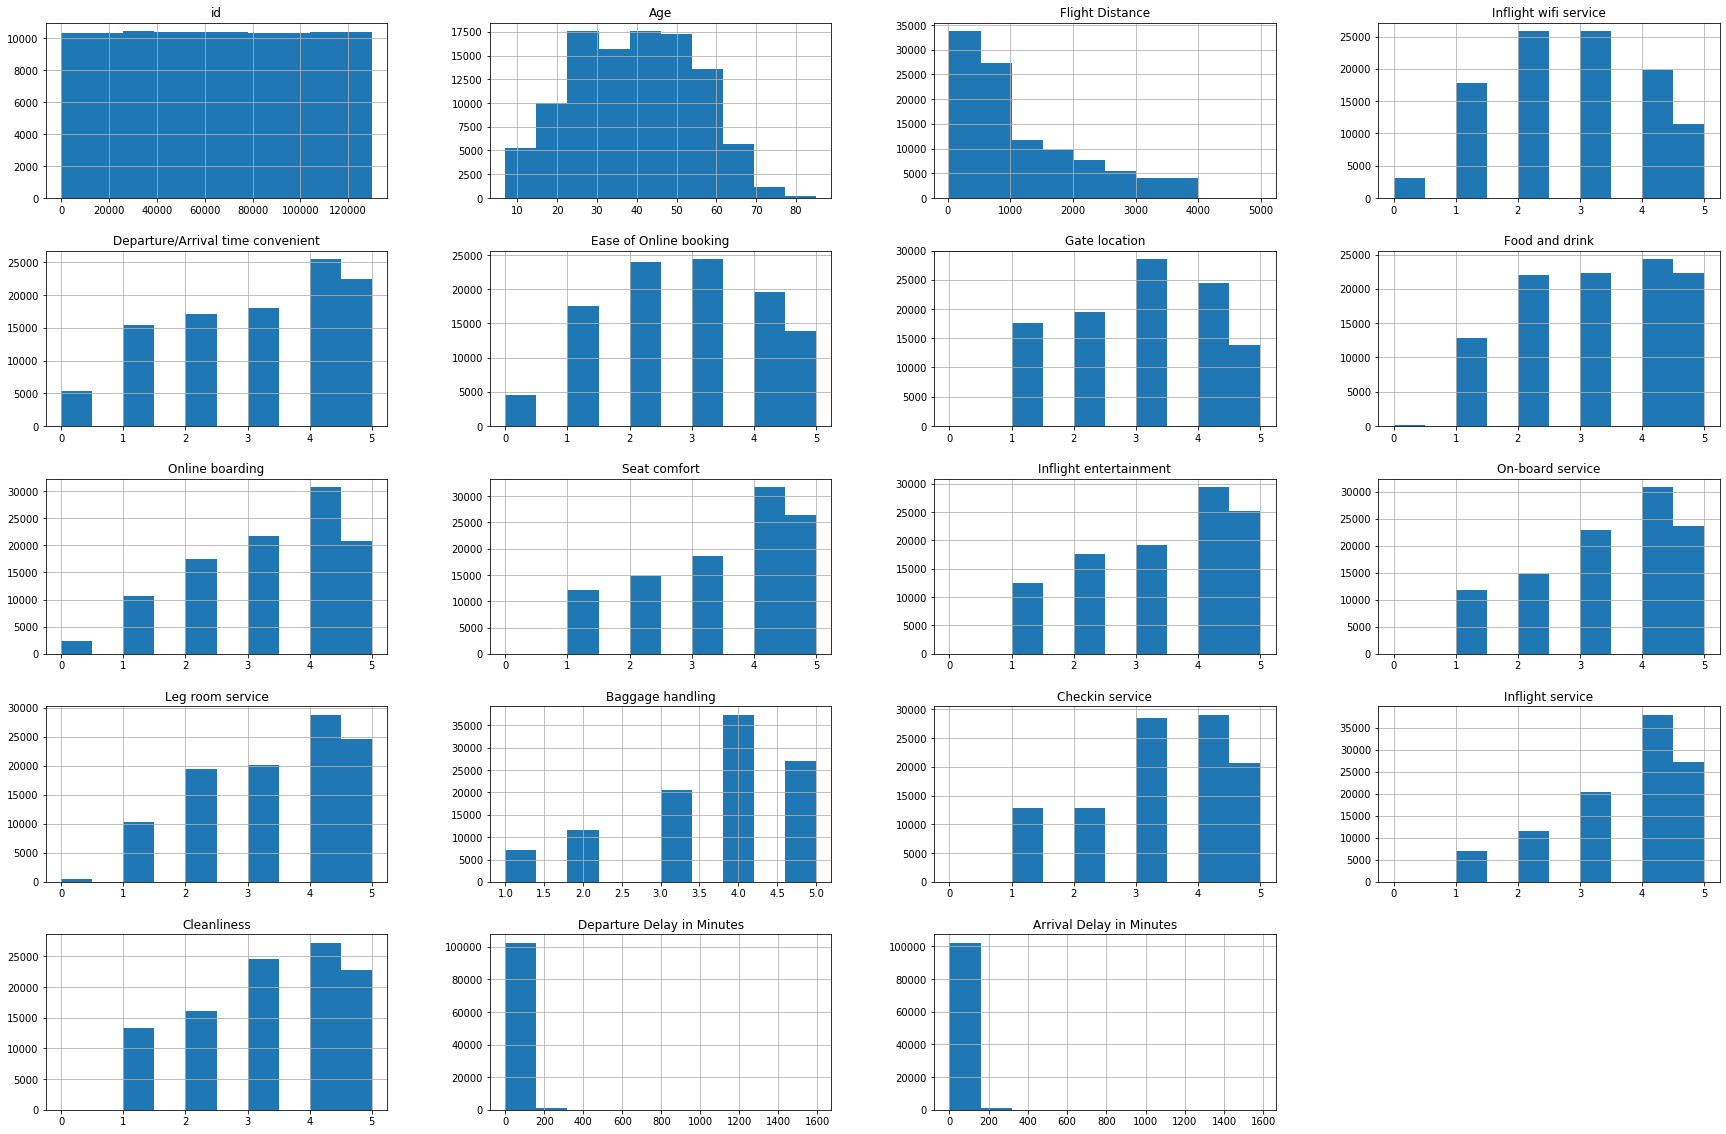

In [9]:
h = train.hist(figsize=(30,20))

In [10]:
Categorical_columns = train.select_dtypes(include=['object'])
Numerical_columns = train.select_dtypes(exclude=['object'])

In [11]:
Categorical_columns.describe().T

,count,unique,top,freq
Gender,103904,2,Female,52727
Customer Type,103904,2,Loyal Customer,84923
Type of Travel,103904,2,Business travel,71655
Class,103904,3,Business,49665
satisfaction,103904,2,neutral or dissatisfied,58879


범주형 컬럼들을 살펴보면 성별에 male, female로, Customer Type(고객유형)은 Loyal Customer(단골고객), disloyal Custome(단골 아닌 고객)으로 나뉘어져 있습니다.

또 Type of Travel(여행유형)에는 Personal Travel(개인여행), Business travel(출장)으로, class에는 Eco(이코노미), Eco Plus(이코노미 플러스), Business(비즈니스)좌석으로 나눠져 있습니다.

저희가 분석해야 할 타겟컬럼인 satisfaction(만족도)에는 neutral or dissatisfied(중립 또는 불만족), satisfied(만족)으로 나눠져있습니다.

In [12]:
Numerical_columns.describe().T

,count,mean,std,min,25%,50%,75%,max
id,103904.0,64924.210502,37463.812252,1.0,32533.75,64856.5,97368.25,129880.0
Age,103904.0,39.379706,15.114964,7.0,27.00,40.0,51.00,85.0
Flight Distance,103904.0,1189.448375,997.147281,31.0,414.00,843.0,1743.00,4983.0
Inflight wifi service,103904.0,2.729683,1.327829,0.0,2.00,3.0,4.00,5.0
Departure/Arrival time convenient,103904.0,3.060296,1.525075,0.0,2.00,3.0,4.00,5.0
Ease of Online booking,103904.0,2.756901,1.398929,0.0,2.00,3.0,4.00,5.0
Gate location,103904.0,2.976883,1.277621,0.0,2.00,3.0,4.00,5.0
Food and drink,103904.0,3.202129,1.329533,0.0,2.00,3.0,4.00,5.0
Online boarding,103904.0,3.250375,1.349509,0.0,2.00,3.0,4.00,5.0
Seat comfort,103904.0,3.439396,1.319088,0.0,2.00,4.0,5.00,5.0


수치형 컬럼에는 id 고객들의 고유번호이고, Age는 고객들의 나이, 

비행시간, 도착지연시간, 출발지연시간이 있고,

나머지컬럼은 각 서비스에 대한 리커트척도로 받은 답변입니다. Likert(리커트)척도란 '전혀 아니다', '아니다', '보통이다', '그렇다', '매우그렇다'의 정도를 표시하도록 하는 측정방법으로써 질문에 대해 더 자세한 피드백을 받도록 해줍니다. 이 데이터에서 0점은 '평가되지 않음'이고, 1점이 '전혀 아니다', 3점이 '보통이다' 5점이 '매우 좋다'로 설문조사하였습니다.

In [13]:
train.nlargest(10, 'Departure Delay in Minutes')

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
83741,73471,Female,Loyal Customer,47,Personal Travel,Eco,1120,2,2,2,...,2,4,4,4,2,3,2,1592,1584.0,neutral or dissatisfied
6744,69661,Male,Loyal Customer,32,Business travel,Business,2916,2,2,2,...,3,4,5,4,5,3,5,1305,1280.0,satisfied
61310,4903,Male,Loyal Customer,49,Business travel,Business,1959,1,1,1,...,4,4,4,5,4,4,4,1017,1011.0,satisfied
72206,78300,Male,Loyal Customer,30,Personal Travel,Eco,1598,1,4,1,...,5,3,4,4,1,4,1,978,970.0,neutral or dissatisfied
80182,8345,Male,Loyal Customer,47,Business travel,Business,2187,4,5,4,...,5,4,5,5,4,4,4,933,920.0,satisfied
61287,4376,Female,Loyal Customer,53,Business travel,Business,2418,3,4,4,...,3,5,2,2,3,4,3,930,952.0,neutral or dissatisfied
61528,83676,Male,disloyal Customer,43,Business travel,Business,577,3,3,3,...,5,4,5,5,5,3,5,921,924.0,neutral or dissatisfied
27732,69504,Male,Loyal Customer,27,Business travel,Business,1746,1,1,4,...,4,3,5,4,5,4,5,859,860.0,satisfied
51860,79912,Male,Loyal Customer,15,Business travel,Business,3979,2,2,2,...,2,2,4,3,2,3,2,853,823.0,neutral or dissatisfied
37096,78292,Male,Loyal Customer,23,Business travel,Eco,998,5,2,2,...,1,1,2,4,5,1,5,750,729.0,satisfied


In [14]:
train[train['Arrival Delay in Minutes'] == 1280.0]

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
6744,69661,Male,Loyal Customer,32,Business travel,Business,2916,2,2,2,...,3,4,5,4,5,3,5,1305,1280.0,satisfied


https://www.sedaily.com/NewsVIew/22P3NH20R8
# 21시간 지연기사 PPT
출발/도착지연시간에서 상위 10개를 뽑아보면 729분 이상인 값이 몇 개 존재하는데 실제로 지연된 시간이기때문에 이상치라고 생각하지 않습니다. 도착시간이 21시간 지연이었음에도 불구하고 '만족'인 고객이 있었기 때문에 같이 분석하도록 하겠습니다.

In [15]:
missing_num = train.isnull().sum().sort_values(ascending=False)
missing_percentage = missing_num / train.shape[0]
missing_info = pd.concat([missing_num,missing_percentage],axis=1,keys=['missing_number','missing_percentage'])
missing_info

,missing_number,missing_percentage
Arrival Delay in Minutes,310,0.002984
id,0,0.000000
Gender,0,0.000000
Departure Delay in Minutes,0,0.000000
Cleanliness,0,0.000000
Inflight service,0,0.000000
Checkin service,0,0.000000
Baggage handling,0,0.000000
Leg room service,0,0.000000
On-board service,0,0.000000


In [16]:
train[train['Arrival Delay in Minutes'].isnull()]

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
213,49608,Female,Loyal Customer,38,Business travel,Eco,109,5,3,3,...,5,5,2,4,1,1,5,31,NaN,satisfied
1124,73442,Male,Loyal Customer,53,Personal Travel,Eco,1012,3,2,3,...,4,4,4,4,3,3,4,38,NaN,neutral or dissatisfied
1529,71178,Male,Loyal Customer,39,Business travel,Business,733,2,5,5,...,2,2,2,2,2,2,3,11,NaN,neutral or dissatisfied
2004,72940,Female,disloyal Customer,26,Business travel,Business,1035,3,3,3,...,2,3,3,4,5,5,2,41,NaN,neutral or dissatisfied
2108,116374,Female,Loyal Customer,24,Personal Travel,Eco,417,2,1,2,...,5,1,4,2,1,2,5,1,NaN,neutral or dissatisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102067,36729,Male,Loyal Customer,49,Personal Travel,Eco Plus,1249,2,5,2,...,3,4,5,4,3,4,3,230,NaN,neutral or dissatisfied
102384,71241,Male,Loyal Customer,58,Business travel,Eco,733,3,3,3,...,3,3,1,2,4,2,3,55,NaN,neutral or dissatisfied
102552,27684,Female,disloyal Customer,29,Business travel,Eco,1107,2,1,1,...,5,4,1,5,5,3,5,0,NaN,neutral or dissatisfied
102960,36787,Male,Loyal Customer,58,Business travel,Eco,1088,4,4,1,...,5,1,5,5,5,3,5,0,NaN,satisfied


결측치는 도착시간지연(분)컬럼에서만 존재하고 있습니다. 도착시간지연은 대부분 출발시간 지연이 원인이기때문에 출발시간지연값과 같은 값으로 채워주겠습니다. 

In [17]:
def engineer(df):
                
  # 'id'는 고유번호이기 때문에 제거
  df = df.drop(['id'], axis=1) 
  df = df.reset_index(drop=True)

  # 도착시간지연 결측치 출발시간지연값으로 채우기
  df['Arrival Delay in Minutes'] = np.where(pd.notnull(df['Arrival Delay in Minutes']) == True, df['Arrival Delay in Minutes'], df['Departure Delay in Minutes'])

  return df

train = engineer(train)
test = engineer(test)

In [18]:
train[train['Arrival Delay in Minutes'].isnull()]

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction


In [19]:
train

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103899,Female,disloyal Customer,23,Business travel,Eco,192,2,1,2,3,...,2,3,1,4,2,3,2,3,0.0,neutral or dissatisfied
103900,Male,Loyal Customer,49,Business travel,Business,2347,4,4,4,4,...,5,5,5,5,5,5,4,0,0.0,satisfied
103901,Male,disloyal Customer,30,Business travel,Business,1995,1,1,1,3,...,4,3,2,4,5,5,4,7,14.0,neutral or dissatisfied
103902,Female,disloyal Customer,22,Business travel,Eco,1000,1,1,1,5,...,1,4,5,1,5,4,1,0,0.0,neutral or dissatisfied


# 가설세우기

### 가설 1. 물리적서비스가 만족도에 영향을 주는가?
물리적서비스 중 기내식과 좌석의 편안함, 기내 엔터테인먼트, 레그룸 이 네 가지 서비스는 설문조사 점수가 높을수록 만족도에서 '만족'이 나왔습니다. 하지만 게이트위치는 만족도와 크게 상관없는 것으로 보입니다.

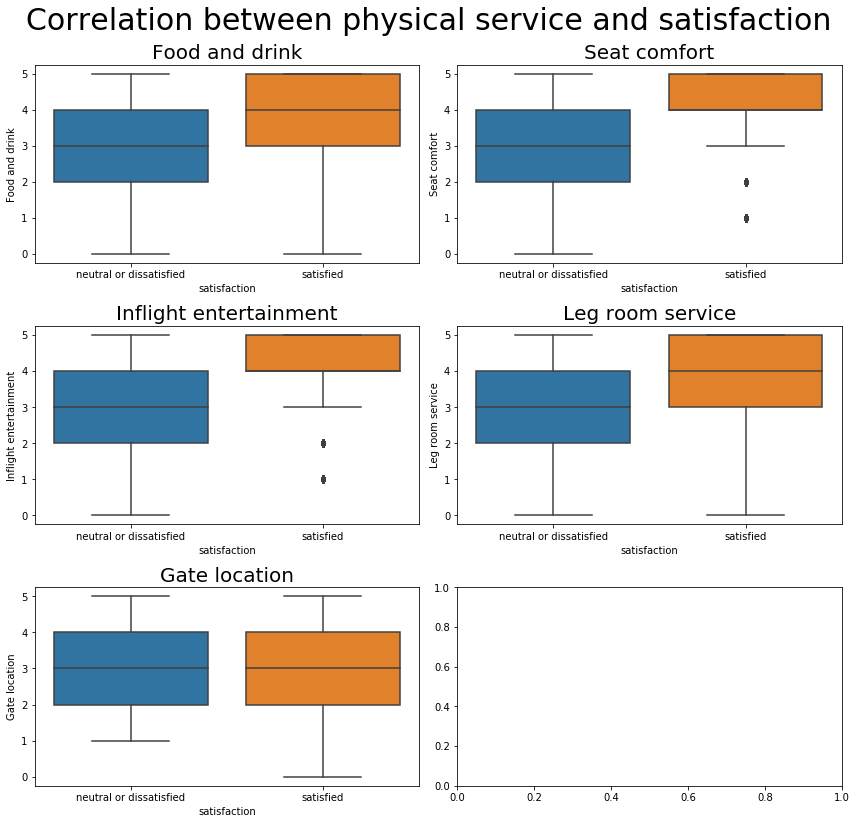

In [20]:
physical = train.loc[:, ['Food and drink', 'Seat comfort', 'Inflight entertainment', 'Leg room service','Gate location', 'satisfaction']]

fig, axes = plt.subplots(3, 2, figsize=(12, 12))

fig.suptitle('Correlation between physical service and satisfaction', fontsize= 30)
for ax, col in zip(axes.flat, physical.columns[:-1]):
    sns.boxplot(x= 'satisfaction',y= col, ax=ax, data=physical)
    ax.set_title(col, fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 가설 1-1. 게이트위치와 만족도에 상관관계가 없다.
게이트위치의 점수를 매우 좋다인 5점으로 주었을 때 만족도가 더 높지만, 3점과 4점에서는 불만족이 훨씬 높게 나온 것을 볼 수 있습니다. 게이트위치 만족도와 항공사 이용 만족도는 무의미한 관계라고 볼 수 있습니다.


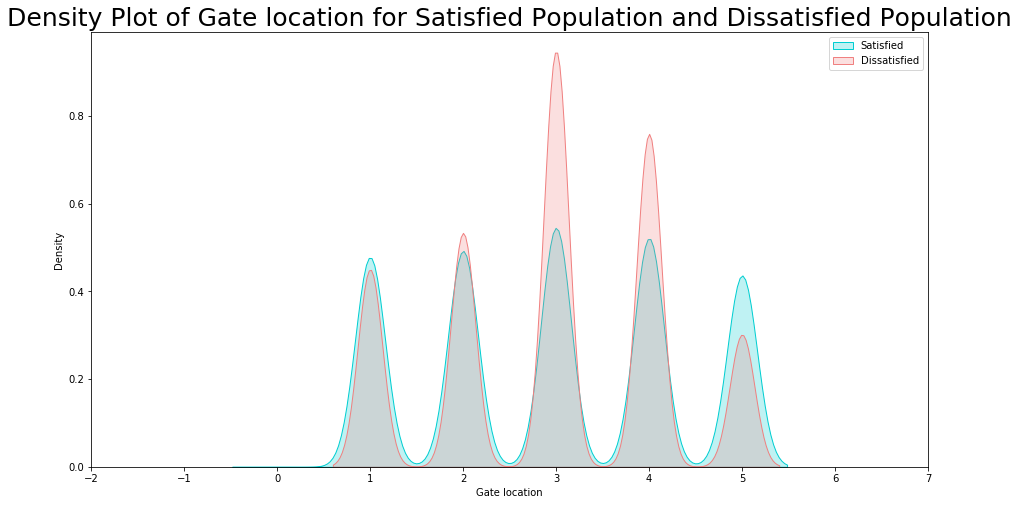

In [21]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(train['Gate location'][train['satisfaction'] == 'satisfied'], color="darkturquoise", shade=True)
sns.kdeplot(train['Gate location'][train['satisfaction'] == 'neutral or dissatisfied'], color="lightcoral", shade=True)
plt.legend(['Satisfied', 'Dissatisfied'])
plt.title('Density Plot of Gate location for Satisfied Population and Dissatisfied Population', fontsize= 25)
ax.set(xlabel='Gate location')
plt.xlim(-2, 7)
plt.show()

### 가설 2. 편의성서비스는 만족도에 영향을 주는가?
편의성서비스 중 기내 와이파이서비스의 만족도 점수가 높은만큼 항공사 만족도도 높은 것으로 보입니다. 하지만 편리한 출발/도착시간, 출발지연시간, 도착지연시간은 만족도에 큰 영향이 없는 것으로 보입니다.

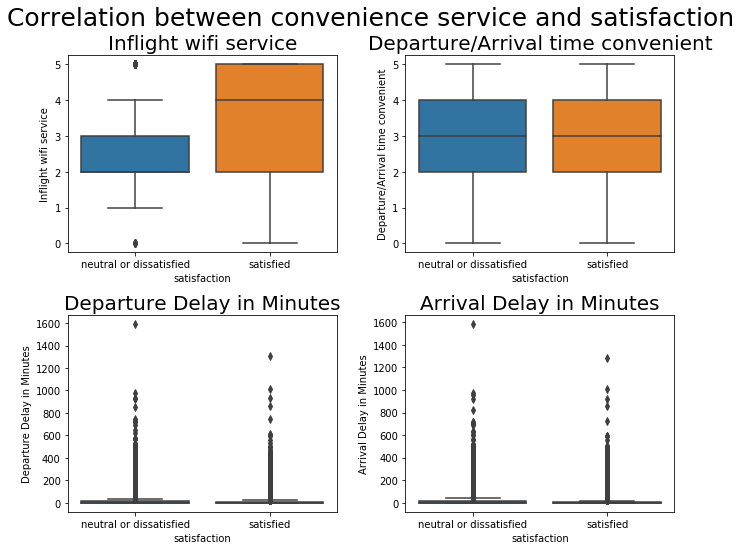

In [22]:
convenience = train.loc[:, ['Inflight wifi service', 'Departure/Arrival time convenient', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'satisfaction']]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

fig.suptitle('Correlation between convenience service and satisfaction', fontsize= 25)
for ax, col in zip(axes.flat, convenience.columns[:-1]):
    sns.boxplot(x= 'satisfaction', y= col, ax=ax, data=convenience)
    ax.set_title(col, fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 가설 2-1. 출발/도착지연시간이 만족도와 상관관계가 없다.
출발시간지연이나 도착시간지연이 없을때는 확실히 만족도가 높습니다. 하지만 delay가 존재할 때 만족과 불만족의 차이가 없는것으로 보아 상관관계가 크게 없어 보입니다.


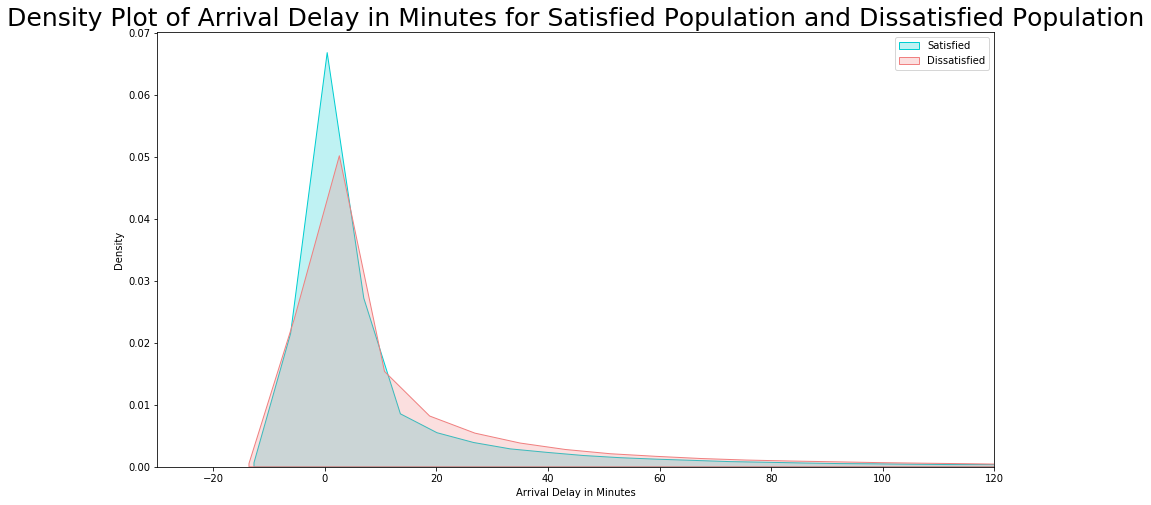

In [23]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(train['Arrival Delay in Minutes'][train['satisfaction'] == 'satisfied'], color="darkturquoise", shade=True)
sns.kdeplot(train['Arrival Delay in Minutes'][train['satisfaction'] == 'neutral or dissatisfied'], color="lightcoral", shade=True)
plt.legend(['Satisfied', 'Dissatisfied'])
plt.title('Density Plot of Arrival Delay in Minutes for Satisfied Population and Dissatisfied Population', fontsize= 25)
ax.set(xlabel='Arrival Delay in Minutes')
plt.xlim(-30,120)
plt.show()

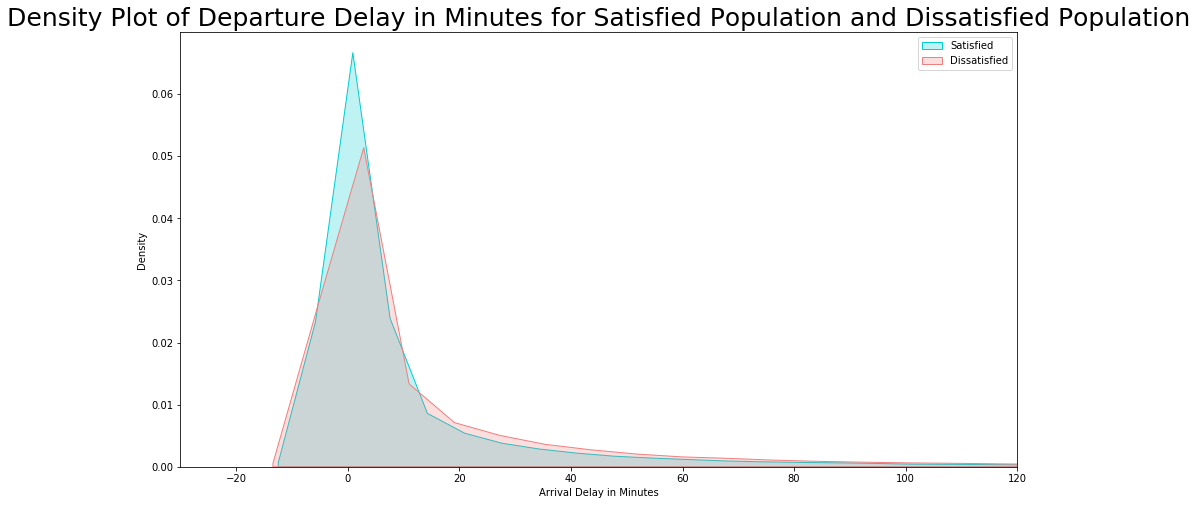

In [24]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(train['Departure Delay in Minutes'][train['satisfaction'] == 'satisfied'], color="darkturquoise", shade=True)
sns.kdeplot(train['Departure Delay in Minutes'][train['satisfaction'] == 'neutral or dissatisfied'], color="lightcoral", shade=True)
plt.legend(['Satisfied', 'Dissatisfied'])
plt.title('Density Plot of Departure Delay in Minutes for Satisfied Population and Dissatisfied Population', fontsize= 25)
ax.set(xlabel='Arrival Delay in Minutes')
plt.xlim(-30,120)
plt.show()

### 가설 2-2. 편리한 출발/도착시간이 만족도와 상관관계가 없다.
편리한 출발/도착 점수에서 4, 5점을 주었지만 불만족이 더 높게 나온 것을 볼 수 있고, 1점(전혀 아니다)를 주었지만 만족이 더 높게 나온 것으로 보아 편리한 출발/도착시간과 만족도는 무의미한 관계라고 볼 수 있습니다.

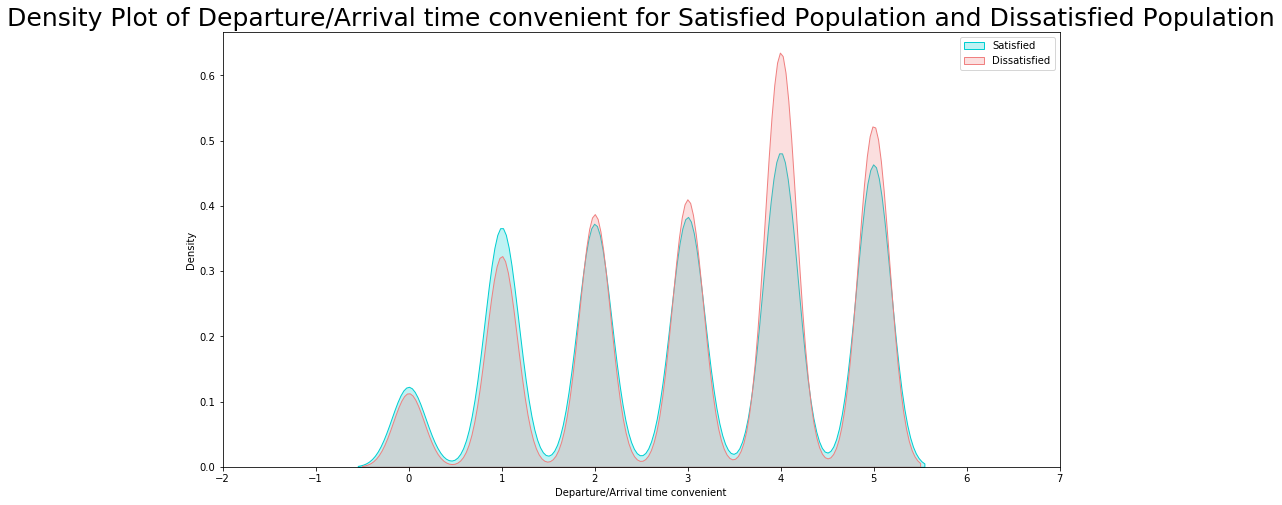

In [25]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(train['Departure/Arrival time convenient'][train['satisfaction'] == 'satisfied'], color="darkturquoise", shade=True)
sns.kdeplot(train['Departure/Arrival time convenient'][train['satisfaction'] == 'neutral or dissatisfied'], color="lightcoral", shade=True)
plt.legend(['Satisfied', 'Dissatisfied'])
plt.title('Density Plot of Departure/Arrival time convenient for Satisfied Population and Dissatisfied Population', fontsize= 25)
ax.set(xlabel='Departure/Arrival time convenient')
plt.xlim(-2,7)
plt.show()

### 가설 3. 정보제공서비스는 만족도에 영향을 주는가?
쉬운 온라인예약, 온라인탑승정보, 체크인서비스도 점수가 높은만큼 '만족'이 나오는 것으로 보아 만족도와 유의미한 변수라고 할 수 있습니다.

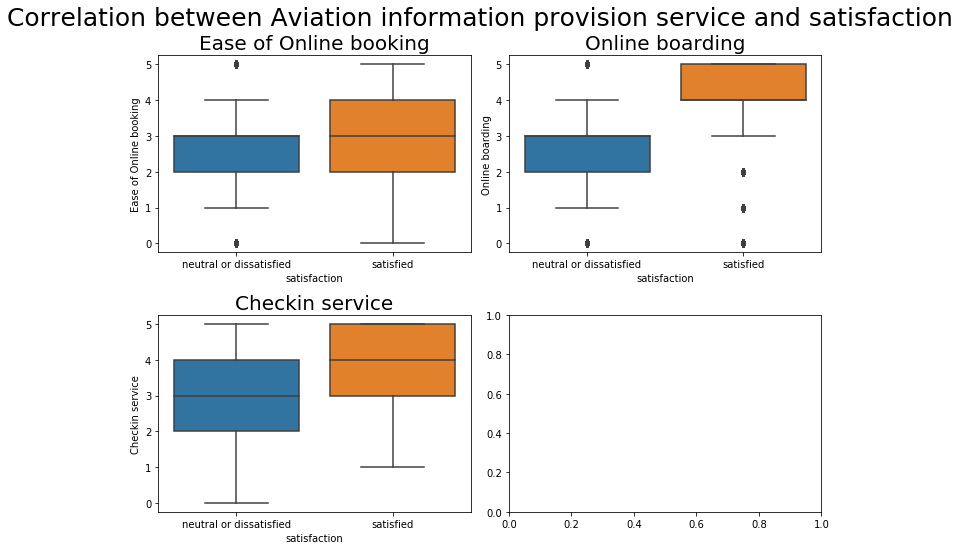

In [26]:
inpormation = train.loc[:, ['Ease of Online booking', 'Online boarding', 'Checkin service', 'satisfaction']]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

fig.suptitle('Correlation between Aviation information provision service and satisfaction', fontsize= 25)
for ax, col in zip(axes.flat, inpormation.columns[:-1]):
    sns.boxplot(x= 'satisfaction', y= col, ax=ax, data=inpormation)
    ax.set_title(col, fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 가설 4. 인적서비스는 만족도에 영향을 주는가?
인적서비스인 on-board 서비스, 수하물취급, 기내서비스, 청결도 모두 만족도와 상관관계가 높습니다.

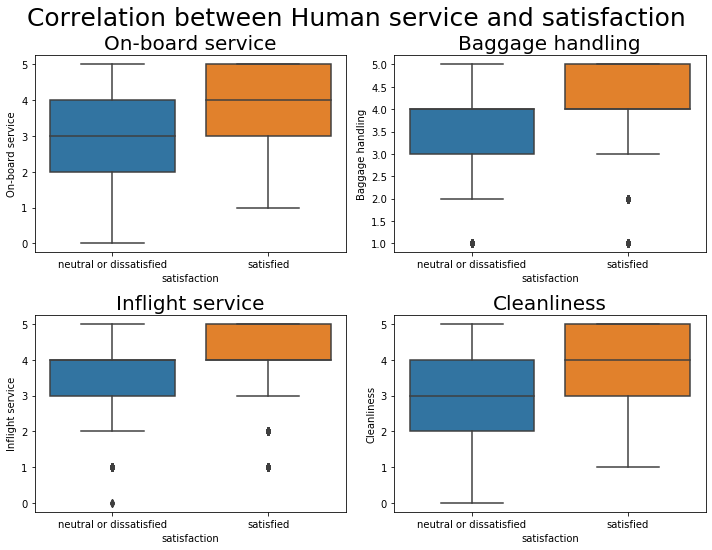

In [27]:
human = train.loc[:, ['On-board service', 'Baggage handling', 'Inflight service', 'Cleanliness', 'satisfaction']]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

fig.suptitle('Correlation between Human service and satisfaction', fontsize= 25)
for ax, col in zip(axes.flat, human.columns[:-1]):
    sns.boxplot(x= 'satisfaction', y= col, ax=ax, data=human)
    ax.set_title(col, fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 서비스 결론 : 게이트위치, 편리한 출발/도착시간, 출발/도착지연시간은 만족도에 영향을 주지 않습니다. 다른 기내 서비스에 대해서는 만족도가 높은만큼 항공사 만족도도 좋은 것으로 분석할 수 있습니다.

### 가설 5. 나이와 만족도는 상관관계가 있다.
'만족'의 경우 30대 후반에서 50대 후반까지 가장 많았고, 불만족의 경우 20대, 30대에서 많은 것을 볼 수 있습니다. 나이와 만족도가 유의미한 관계라고 볼 수 있습니다.

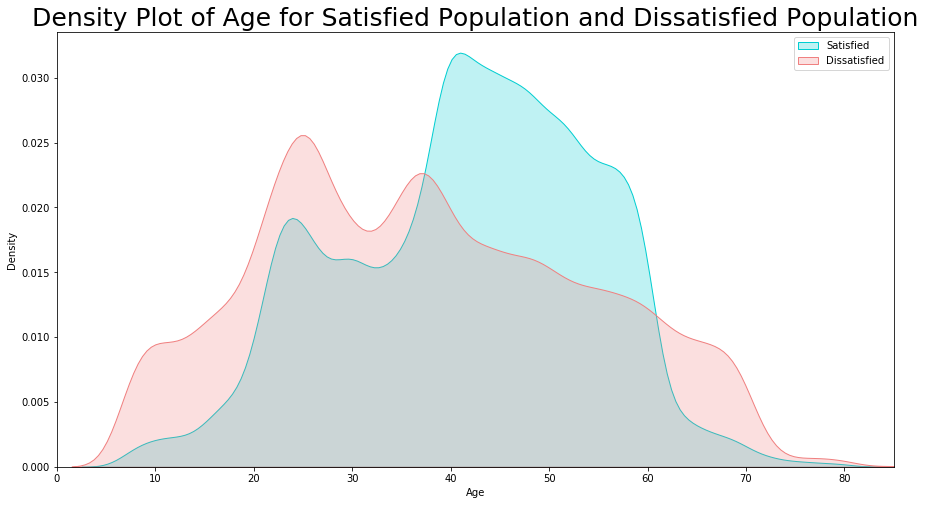

In [28]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(train["Age"][train['satisfaction'] == 'satisfied'], color="darkturquoise", shade=True)
sns.kdeplot(train["Age"][train['satisfaction'] == 'neutral or dissatisfied'], color="lightcoral", shade=True)
plt.legend(['Satisfied', 'Dissatisfied'])
plt.title('Density Plot of Age for Satisfied Population and Dissatisfied Population', fontsize = 25)
ax.set(xlabel='Age')
plt.xlim(0,85)
plt.show()

### 가설 6. 비행거리와 만족도에 상관관계가 있다.
비행거리가 길수록 불만족이 높을거라고 생각했지만 1000이하인 거리에서 불만족이 높게 나왔고, 그 이상일때 만족이 높게 나왔습니다. 확실한 차이가 보이므로 유의미한 변수라고 생각할 수 있습니다.

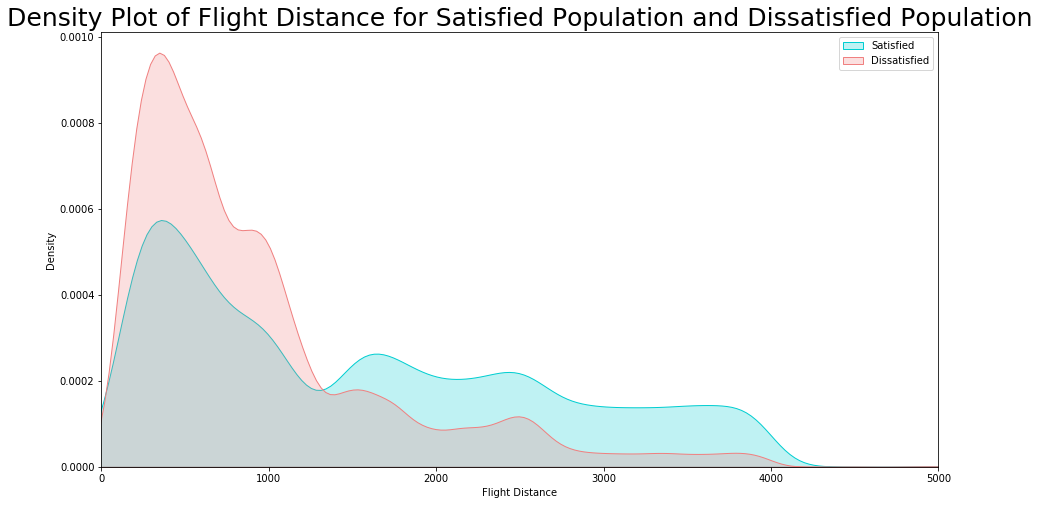

In [29]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(train['Flight Distance'][train['satisfaction'] == 'satisfied'], color="darkturquoise", shade=True)
sns.kdeplot(train['Flight Distance'][train['satisfaction'] == 'neutral or dissatisfied'], color="lightcoral", shade=True)
plt.legend(['Satisfied', 'Dissatisfied'])
plt.title('Density Plot of Flight Distance for Satisfied Population and Dissatisfied Population',  fontsize = 25)
ax.set(xlabel='Flight Distance')
plt.xlim(0,5000)
plt.show()

### 가설 7. 성별이 만족도와 상관관계가 있다.
성별이 같은 비율로 만족과 불만족으로 나누어진것으로 보아 상관관계가 없습니다.

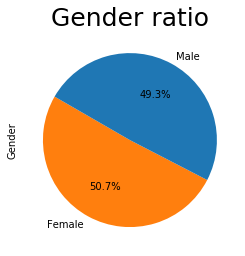

In [30]:
train_Gender = train['Gender'].value_counts()
train_Gender.plot(kind='pie', autopct='%1.1f%%', colors = ['C1', 'C0'], startangle=150)
plt.title('Gender ratio', fontsize=25);

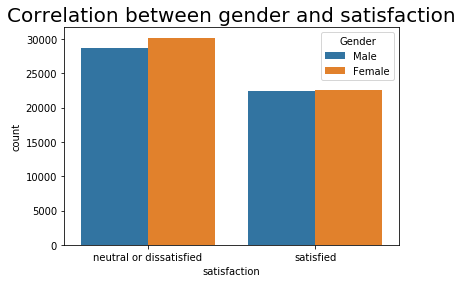

In [31]:
sns.countplot(x = 'satisfaction', hue ='Gender', data = train)
plt.title('Correlation between gender and satisfaction', fontsize = 20)
plt.show()

### 가설 8. 좌석(class)이 만족도와 상관관계가 있다.
좌석이 이코노미일때 만족보다 불만족이 많이 높습니다. 비즈니스일때는 불만족보다 만족이 높습니다. 
좌석의 편안함이 이코노미 < 이코노미플러스 < 비즈니스 이기때문에 비즈니스를 이용한 고객은 만족도가 높고, 이코노미를 이용한 고객들은 불만족이 높은 것으로 보입니다. 이코노미플러스는 그 중간좌석이라고 생각하시면 되는데 불만족이 더 높은 것으로 나옵니다. 이코노미플러스는 Class전체에서 7%이지만 불만족이 세 배인 것으로 보아 좌석과 만족도는 상관관계가 있어보입니다. 

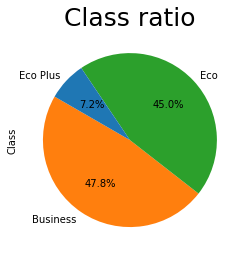

In [32]:
train_Gender = train['Class'].value_counts()
train_Gender.plot(kind='pie', autopct='%1.1f%%', colors = ['C1', 'C2', 'C0'], startangle=150)
plt.title('Class ratio', fontsize=25);

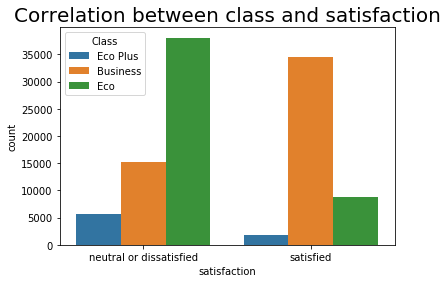

In [33]:
sns.countplot(x = 'satisfaction', hue ='Class', data = train)
plt.title('Correlation between class and satisfaction', fontsize=20)
plt.show()

### 가설 9. 여행유형과 만족도는 상관관계가 있다.
여행유형에는 출장이 70%, 개인여행이 30%로 출장이 더 많았는데 출장인 경우에 만족도가 높고, 개인여행일때는 불만족이 훨씬 높은 것으로 보아 개인여행일때 만족도에 대한 기준이 더 높은 것으로 보입니다. 여행유형과 만족도는 유의미한 관계라고 볼 수 있습니다.

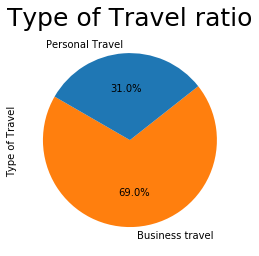

In [34]:
train_Gender = train['Type of Travel'].value_counts()
train_Gender.plot(kind='pie', autopct='%1.1f%%', colors = ['C1', 'C0'], startangle=150)
plt.title('Type of Travel ratio', fontsize=25);

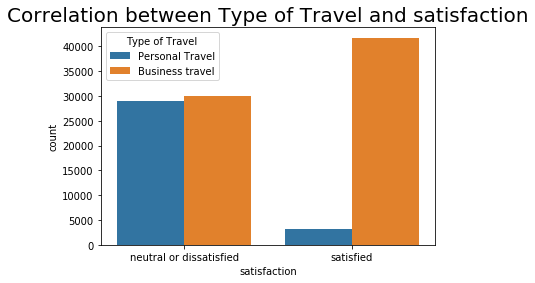

In [35]:
sns.countplot(x = 'satisfaction', hue ='Type of Travel', data = train)
plt.title('Correlation between Type of Travel and satisfaction', fontsize = 20)
plt.show()

### 가설 10. 고객유형과 만족도는 상관관계가 있다.
만족, 불만족 모두 단골고객이 단골이 아닌고객보다 수가 높습니다. 
하지만 실제 고객유형에서 단골고객이 81%이기때문에 이렇게 해석하지 않고, 단골고객이 불만족과 만족 반반을 차지하고, 
단골이 아닌 고객은 불만족이 만족의 3배인 것으로 보아 단골이 아닌 고객을 잡기 위해서는 항공사 서비스개선이 꼭 필요하다고 생각합니다.

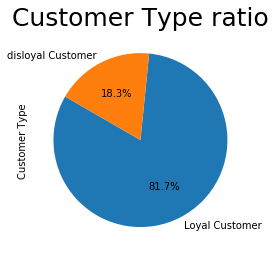

In [36]:
train_Gender = train['Customer Type'].value_counts()
train_Gender.plot(kind='pie', autopct='%1.1f%%', colors = ['C0', 'C1'], startangle=150)
plt.title('Customer Type ratio', fontsize=25);

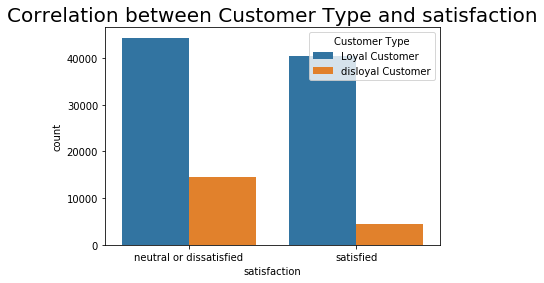

In [37]:
sns.countplot(x = 'satisfaction', hue ='Customer Type', data = train)
plt.title('Correlation between Customer Type and satisfaction', fontsize = 20)
plt.show()

# 히트맵
히트맵을 통해 만족도와 특성들의 상관계수를 구해보고, 다시 한 번 상관관계를 살펴보겠습니다.
히트맵을 이용하면 Target Feature인 '만족도'와 나머지 특성들의 상관계수를 직관적으로 확인할 수 있습니다.
상관계수는 -1부터 1사이로 구성되고, 0.3부터 0.7 사이면 뚜렷한 양의 선형관계, 0.7 이상이면 강한 양의 선형관계라 할 수 있습니다. -는 음의 선형관계입니다.

위에서 살펴본대로 타겟과의 상관계수가 출발지연시간은 -0.06, 편리한 출발/도착시간은 -0.05, 게이트위치는 0.00068, 성별은 0.01으로서 0에 가까운 상관계수를 가졌고, 이는 만족도에 영향을 미치지않는다고 볼 수 있습니다. (연한 하늘색 = 0)

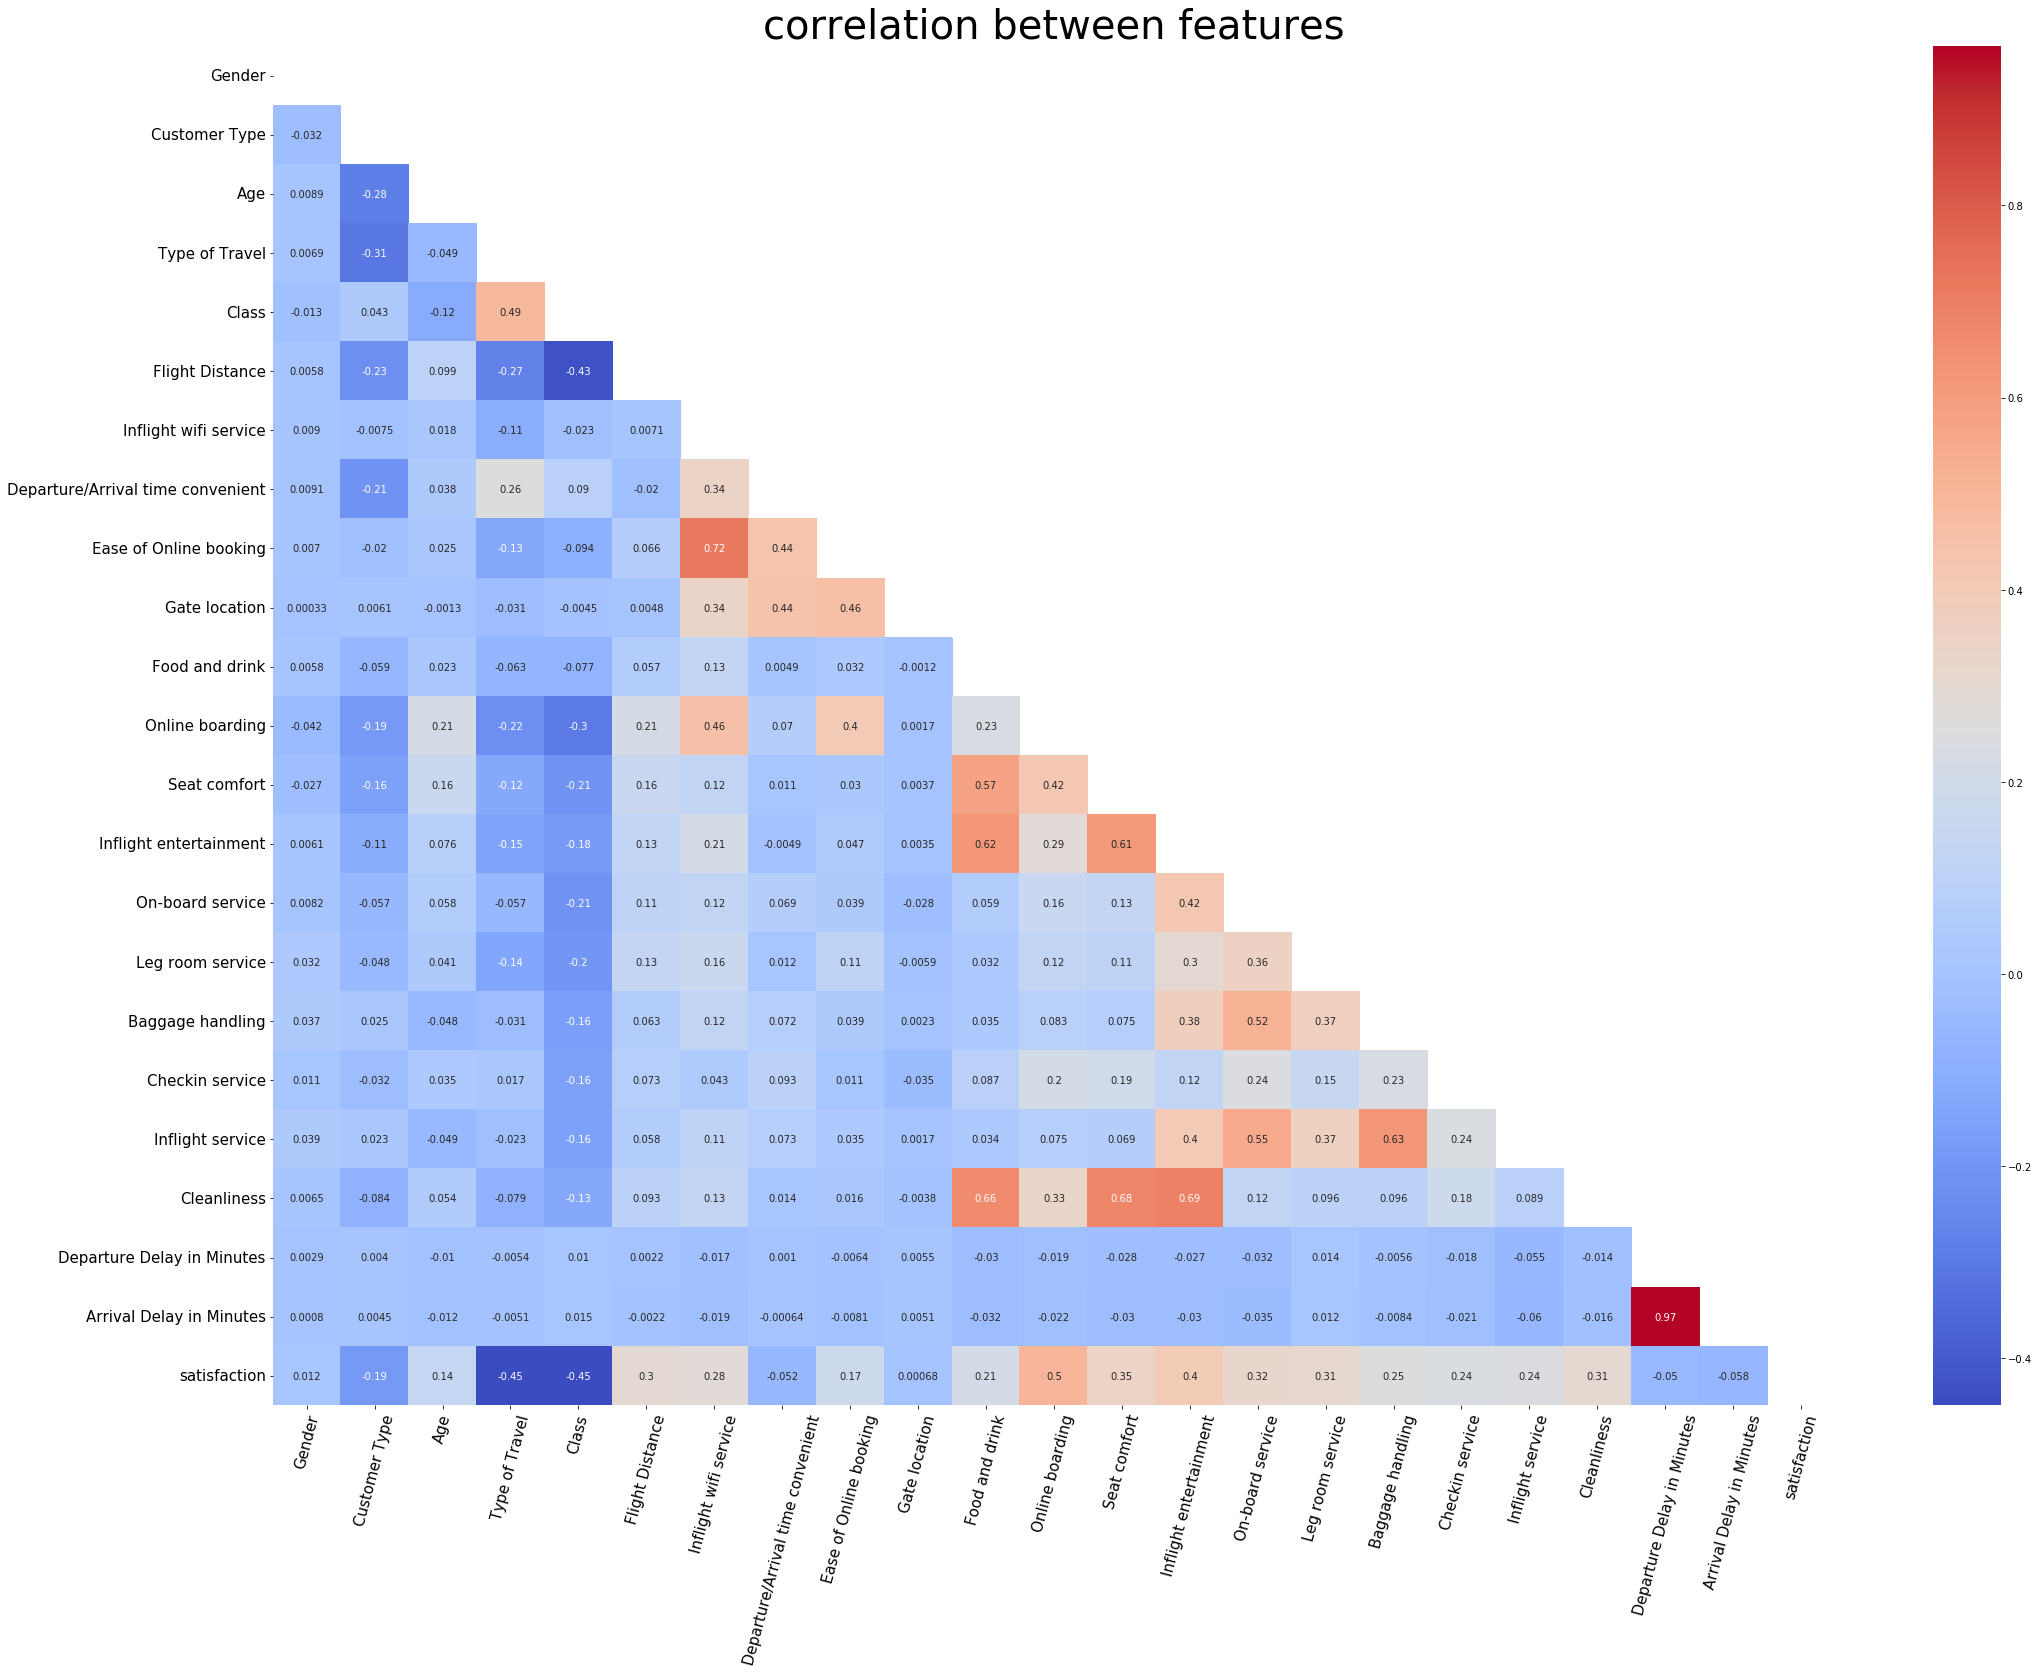

In [38]:
from sklearn.preprocessing import LabelEncoder
corr_df = train.copy()
corr_df[corr_df.columns[corr_df.dtypes=='O']] = corr_df[corr_df.columns[corr_df.dtypes=='O']].astype(str).apply(LabelEncoder().fit_transform)
# 범주형데이터 숫자화 
plt.figure(figsize=(35,25))

heat_table = corr_df.corr()
mask = np.zeros_like(heat_table)
mask[np.triu_indices_from(mask)] = True
heatmap_ax = sns.heatmap(heat_table, annot=True, mask = mask, cmap='coolwarm')
heatmap_ax.set_xticklabels(heatmap_ax.get_xticklabels(), fontsize=15, rotation=75)
heatmap_ax.set_yticklabels(heatmap_ax.get_yticklabels(), fontsize=15)
plt.title('correlation between features', fontsize=40)

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

In [39]:
heat_table['satisfaction'].sort_values()

Class                               -0.449321
Type of Travel                      -0.449000
Customer Type                       -0.187638
Arrival Delay in Minutes            -0.057522
Departure/Arrival time convenient   -0.051601
Departure Delay in Minutes          -0.050494
Gate location                        0.000682
Gender                               0.012211
Age                                  0.137167
Ease of Online booking               0.171705
Food and drink                       0.209936
Checkin service                      0.236174
Inflight service                     0.244741
Baggage handling                     0.247749
Inflight wifi service                0.284245
Flight Distance                      0.298780
Cleanliness                          0.305198
Leg room service                     0.313131
On-board service                     0.322383
Seat comfort                         0.349459
Inflight entertainment               0.398059
Online boarding                   

---
---

In [41]:
train, val = train_test_split(train, test_size=0.2, random_state=2)
train.shape, val.shape, test.shape
((83123, 19), (20781, 19), (25976, 19))

((83123, 19), (20781, 19), (25976, 19))

In [42]:
target = 'satisfaction'
features = train.columns.drop([target])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

## 기준모델은 분류문제이기때문에 최빈값으로 정하였습니다. 정확도는 0.56 입니다.

In [43]:
# 기준모델
from sklearn.metrics import accuracy_score

major = y_train.mode()[0]
y_pred = [major] * len(y_train)
print("학습 정확도: ", accuracy_score(y_train, y_pred))

학습 정확도:  0.5668106300301962


# Feature Engineering


# 순열중요도

In [44]:
from sklearn.pipeline import Pipeline

In [45]:
pipe_pm = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder())),
    ('rf', RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)) 
])

In [46]:
pipe_pm.named_steps
pipe_pm.fit(X_train, y_train)
print('검증 정확도: ', pipe_pm.score(X_val, y_val))
# 25초

검증 정확도:  0.9619845050767528


In [47]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    pipe_pm.named_steps['rf'], # model
    scoring='accuracy', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# permuter 계산은 preprocessing 된 X_val을 사용합니다.
X_val_transformed = pipe_pm.named_steps['preprocessing'].transform(X_val)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_val_transformed, y_val);

In [48]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

Gender                              -0.000462
Departure Delay in Minutes           0.000019
Arrival Delay in Minutes             0.000183
Food and drink                       0.000375
Flight Distance                      0.000443
Ease of Online booking               0.000828
Departure/Arrival time convenient    0.001598
Gate location                        0.001877
Age                                  0.002993
Inflight entertainment               0.003821
Leg room service                     0.004456
On-board service                     0.004937
Inflight service                     0.014812
Cleanliness                          0.016804
Seat comfort                         0.016871
Baggage handling                     0.017372
Class                                0.021500
Checkin service                      0.022309
Online boarding                      0.034599
Customer Type                        0.050431
Type of Travel                       0.119821
Inflight wifi service             

In [49]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.1286 ± 0.0049,Inflight wifi service
0.1198 ± 0.0053,Type of Travel
0.0504 ± 0.0015,Customer Type
0.0346 ± 0.0011,Online boarding
0.0223 ± 0.0017,Checkin service
0.0215 ± 0.0012,Class
0.0174 ± 0.0016,Baggage handling
0.0169 ± 0.0026,Seat comfort
0.0168 ± 0.0024,Cleanliness
0.0148 ± 0.0010,Inflight service


중요도가 높은 특성에는 기내 와이파이서비스, 여행유형, 고객유형, 온라인탑승, 체크인서비스, 좌석(Class) 등이 있고, 15위인 게이트위치부터는 중요도가 낮은 것으로 보입니다.

# 중요도를 이용하여 특성을 선택(Feature selection)해 봅시다.
중요도가 -인 특성이나 0.001이하인 특성을 제외해도 성능은 거의 영향이 없으며, 모델학습 속도는 개선됩니다.

In [50]:
minimum_importance = 0.001
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train_selected = X_train[features]
X_val_selected = X_val[features]

In [51]:
print('특성 삭제 후:', X_train_selected.shape, X_val_selected.shape)

특성 삭제 후: (83123, 16) (20781, 16)


In [52]:
# pipeline 다시 정의
pipe = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder())),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)) 
], verbose=1)

pipe.fit(X_train_selected, y_train);

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.2s
[Pipeline] ................ (step 2 of 2) Processing rf, total=   6.6s


In [54]:
print('검증 정확도: ', pipe.score(X_val_selected, y_val))

검증 정확도:  0.9631394061883451


검증정확도가 더 올라감

In [56]:
def engineer2(df):
                      
  # '만족도'에 영향을 미치지않는 특성 제거(게이트위치, 편리한 출발/도착시간, 출발/도착지연시간, 성별)
  # 순열중요도에서 중요도가 낮은 특성도 제거(기내식, 비행거리, 쉬운 온라인예약)
  df = df.drop(['Gate location', 'Departure/Arrival time convenient', 
                'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Gender', 
                'Food and drink', 'Flight Distance', 'Ease of Online booking'], axis=1) 
  df = df.reset_index(drop=True)

  return df

train = engineer2(train)
test = engineer2(test)

분류문제를 풀기 전에 항상 먼저 타겟 범주가 어떤 비율을 가지고 있는지 확인해야 합니다.
불만족과 만족이 학습셋, 검증셋, 테스트셋 모두 0.56, 0.43으로 균형을 이루고 있기 때문에 그대로 진행하겠습니다.

In [57]:
train['satisfaction'].value_counts(normalize=True)

neutral or dissatisfied    0.566811
satisfied                  0.433189
Name: satisfaction, dtype: float64

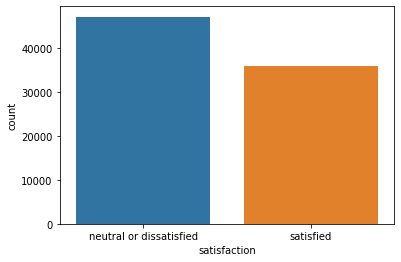

In [58]:
sns.countplot(x=y_train);
# 타겟이 균형을 이루고 있다.

In [59]:
val['satisfaction'].value_counts(normalize=True)

neutral or dissatisfied    0.566094
satisfied                  0.433906
Name: satisfaction, dtype: float64

# 머신러닝 학습시작

# 1. 랜덤포레스트로 모델만들기

## RandomizedSearchCV이용해서 하이퍼파라미터튜닝 -> 모델의 성능을 높혀보겠습니다.

max_depth : 트리의 최대 깊이 (깊이가 깊어지면 과적합될 수 있으므로 적절히 제어 필요)

n_estimators : 결정트리의 갯수를 지정(무작정 트리 갯수를 늘리면 성능 좋아지는 것 대비 시간이 걸릴 수 있음)

max_features : 최적의 분할을 위해 고려할 최대 feature 개수

In [60]:
from sklearn.model_selection import RandomizedSearchCV

In [61]:
pipe_random1 = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(random_state = 42)
)

dists = {
    'randomforestclassifier__max_depth' : [5, 10, 13, 15, 17],
    'randomforestclassifier__max_features' : [3,5,10],
    'randomforestclassifier__n_estimators' : [80, 100, 150]
}

clf = RandomizedSearchCV(
    pipe_random1,
    param_distributions = dists,
    n_iter = 50,
    cv = 5,
    scoring='accuracy',
    n_jobs = -1,
    random_state = 42

)

clf.fit(X_train, y_train)
print('최적 하이퍼파라미터: ', clf.best_params_)
y_val_pred = clf.predict(X_val)
print('검증 정확도:', clf.best_score_)
# 최적 하이퍼파라미터:  {'randomforestclassifier__n_estimators': 150, 'randomforestclassifier__max_features': 10, 
#'randomforestclassifier__max_depth': 17}
# 0.9621
# 28분걸림

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 45 is smaller than n_iter=50. Running 45 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


최적 하이퍼파라미터:  {'randomforestclassifier__n_estimators': 150, 'randomforestclassifier__max_features': 10, 'randomforestclassifier__max_depth': 17}
검증 정확도: 0.9621043658231236


In [67]:
print('학습세트 정확도', clf.score(X_train, y_train))
print('검증세트 정확도', clf.score(X_val, y_val))
y_clf_val_pred = clf.predict(X_val)
print(classification_report(y_val, y_clf_val_pred))
# satisfied기준 precision : 0.97,  recall : 0.94 ,  f1-score : 0.96

학습세트 정확도 0.9868267507188143
검증세트 정확도 0.963620614984842
                         precision    recall  f1-score   support

neutral or dissatisfied       0.96      0.98      0.97     11764
              satisfied       0.97      0.94      0.96      9017

               accuracy                           0.96     20781
              macro avg       0.96      0.96      0.96     20781
           weighted avg       0.96      0.96      0.96     20781



.best_params_를 통해서 최적의 하이퍼파라미터를 체크할 수 있습니다. 또한 clf에는 최적의 파라미터가 들어있는 해당 분류기가 이미 들어가 있으므로 .best_score_로 scoring(accuracy) 해놓은 metric에 대한 최고 성능 값을 구할 수 있습니다.

-----
#2. XGBoost로 모델만들기


max_depth : 트리의 깊이

min_child_weight(기본값1) : leaf node에 포함되는 최소 관측 수, 작은값을 가질수록 과적합 발생 가능성높음 

colsample_bytree(기본값1) : 트리 생성에 필요한 피처의 샘플링에 사용

n_estimators : 약한 학습기의 개수. 약한 학습기가 순차적으로 오류를 보정하므로 개수가 많을수록 예측 성능이 좋아짐

과적합을 제어하려면 

learning rate 값을 낮춥니다.(0.01 ~ 0.1) → learning rate 값을 낮추면 n_estimator를 반대로 높여주어야 합니다.
max_depth 값을 낮춥니다.
min_child_weight 값을 높입니다.
colsample_bytree를 낮춥니다.


In [63]:
from xgboost import XGBClassifier
pipe_xg = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier()
)
dists = {
    'xgbclassifier__max_depth': [5,7,10],
    'xgbclassifier__min_child_weight': [5,10],
    'xgbclassifier__colsample_bytree': [0.8, 0.9],
    'xgbclassifier__n_estimators': [300,400],
}

clf2 = RandomizedSearchCV(
    pipe_xg,
    param_distributions = dists,
    n_iter = 50,
    cv = 5,
    scoring = 'accuracy'
    )
    
clf2.fit(X_train, y_train)
# 1시간13분1초

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('xgbclassifier',
                                              XGBClassifier())]),
                   n_iter=50,
                   param_distributions={'xgbclassifier__colsample_bytree': [0.8,
                                                                            0.9],
                                        'xgbclassifier__max_depth': [5, 7, 10],
                                        'xgbclassifier__min_child_weight': [5,
                                                                            10],
                                        'xgbclassifier__n_estimators': [300,
                                                                        400]},
                   scoring='accuracy')

In [64]:
print('최적 하이퍼파라미터: ', clf2.best_params_)
# 'xgbclassifier__n_estimators': 400, 'xgbclassifier__min_child_weight': 10, 
# 'xgbclassifier__max_depth': 7, 'xgbclassifier__colsample_bytree': 0.8

최적 하이퍼파라미터:  {'xgbclassifier__n_estimators': 400, 'xgbclassifier__min_child_weight': 10, 'xgbclassifier__max_depth': 7, 'xgbclassifier__colsample_bytree': 0.8}


In [68]:
print('학습세트 정확도', clf2.score(X_train, y_train))
print('검증세트 정확도', clf2.score(X_val, y_val))
y_clf2_val_pred = clf2.predict(X_val)
print(classification_report(y_val, y_clf2_val_pred))
# satisfied기준 precision : 0.97,  recall : 0.94 ,  f1-score : 0.96

학습세트 정확도 0.9784295561998484
검증세트 정확도 0.9633318897069438
                         precision    recall  f1-score   support

neutral or dissatisfied       0.96      0.98      0.97     11764
              satisfied       0.97      0.95      0.96      9017

               accuracy                           0.96     20781
              macro avg       0.96      0.96      0.96     20781
           weighted avg       0.96      0.96      0.96     20781



# 일반화 성능 확인

In [83]:
processor = make_pipeline(
    OrdinalEncoder()
)

X_train_processed = processor.fit_transform(X_train)
X_test_processed = processor.transform(X_test)

eval_set = [(X_train_processed, y_train), 
            (X_test_processed, y_test)]

# XGBoost 분류기를 학습시킵니다.
model = XGBClassifier(n_estimators= 400, min_child_weight= 10, max_depth= 7, colsample_bytree=0.8,n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', early_stopping_rounds=10)

[0]	validation_0-auc:0.982021	validation_1-auc:0.981541
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.985528	validation_1-auc:0.98521
[2]	validation_0-auc:0.985455	validation_1-auc:0.984812
[3]	validation_0-auc:0.985963	validation_1-auc:0.985375
[4]	validation_0-auc:0.987085	validation_1-auc:0.986621
[5]	validation_0-auc:0.987562	validation_1-auc:0.987113
[6]	validation_0-auc:0.988385	validation_1-auc:0.988007
[7]	validation_0-auc:0.988533	validation_1-auc:0.988088
[8]	validation_0-auc:0.988922	validation_1-auc:0.98847
[9]	validation_0-auc:0.988985	validation_1-auc:0.988536
[10]	validation_0-auc:0.989405	validation_1-auc:0.98892
[11]	validation_0-auc:0.989556	validation_1-auc:0.989051
[12]	validation_0-auc:0.989845	validation_1-auc:0.989297
[13]	validation_0-auc:0.990007	validation_1-auc:0.989435
[14]	validation_0-auc:0.990142	validation_1-auc:0.989598
[

XGBClassifier(colsample_bytree=0.8, max_depth=7, min_child_weight=10,
              n_estimators=400, n_jobs=-1)

In [85]:
from sklearn.metrics import classification_report
y_test_pred = model.predict(X_test_processed)
print(classification_report(y_test, y_test_pred))

                         precision    recall  f1-score   support

neutral or dissatisfied       0.96      0.98      0.97     14573
              satisfied       0.97      0.95      0.96     11403

               accuracy                           0.96     25976
              macro avg       0.96      0.96      0.96     25976
           weighted avg       0.96      0.96      0.96     25976



In [84]:
from sklearn.metrics import roc_auc_score
X_test_processed = processor.transform(X_test)
X_val_processed = processor.transform(X_val)
class_index = 1
y_pred_proba = model.predict_proba(X_test_processed)[:, class_index]
print(f'Test AUC for class "{model.classes_[class_index]}":')
print(roc_auc_score(y_test, y_pred_proba)) # 범위는 0-1, 수치는 높을 수록 좋습니다


Test AUC for class "satisfied":
0.9951856020727047


-----
# SHAP 이용 모델 해석

In [95]:
import shap
shap.initjs()
explainer = shap.Explainer(model)
shap_values=explainer(X_test_processed)
shap.plots.force(shap_values[0])


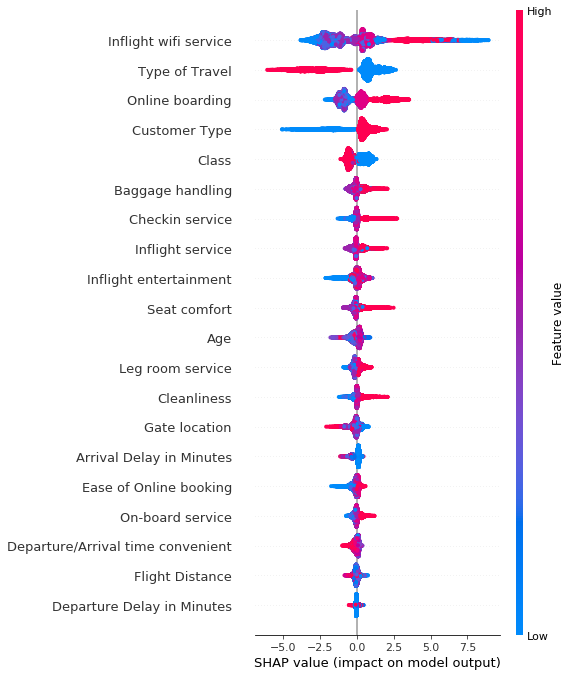

In [96]:
shap.summary_plot(shap_values, X_test_processed)